In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as pch
import matplotlib.lines as lns
from matplotlib.animation import FuncAnimation, PillowWriter
from matplotlib.lines import Line2D
from shapely.geometry import Polygon, Point
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
import os
import json

if 'REPO_PATH' not in locals():
    os.chdir('../../../')
    REPO_PATH = os.getcwd()

print(REPO_PATH)

from dubinstracking.pathplanning import MorphingOrbit, OrbitFactory
from dubinstracking.controller import VectorFieldController
plt.rcParams.update({'font.size': 8})

In [ ]:
with open('data/environments/paper_small/circles.json') as f:
    orbits = [OrbitFactory.fromJson(item) for item in json.load(f)]
controller = VectorFieldController(.5, 40, .2)
all_time = [0]
t_i = 0
t_f = 0
x_0 = [-45, 450, 0]
n = len(orbits)

state_hist = [x_0 + [0 , 0, 0]]
trajectory = [orbits[0].g_0]
radius = [orbits[0].radius(0)]
all_control = [[0, 0]]

for i in range(len(orbits[:n]) - 1):
    distance = np.linalg.norm(orbits[i].g_0 - orbits[i + 1].g_0)
    delta = distance / np.linalg.norm(orbits[i].g_dot_0)
    t_f = t_i + delta
    orbit = MorphingOrbit(orbits[i], orbits[i + 1], t_i, t_f)
    time, state, path, control = controller.solve(orbit, t_i, t_f, x_0, 1e-2)
    state_hist += state.tolist()[1:]
    all_time += time.tolist()[1:]
    trajectory += path.tolist()[:-1]
    all_control += control.tolist()[:-1]
    radius += [orbit.radius(0, t) for t in time[1:]]
    x_0 = state_hist[-1][:len(x_0)]
    t_i = t_f
    print(f'orbit {i + 1}/{len(orbits)}', end='\r')

state_hist = np.array(state_hist)
trajectory = np.array(trajectory)
dist = state_hist[:, :2] - trajectory
theta = np.arctan2(dist[:, 1], dist[:, 0])
all_control = np.array(all_control)
all_time = np.array(all_time)

In [3]:
with open('data/uptownCharlotte.json') as f:
    city = [Polygon(item) for item in json.load(f)]
with open('data/environments/test_small_radius/volumes.json') as f:
    volumes = json.load(f)
    visibility = [np.array(item['polygon']) for item in volumes]
    visibility_points = np.array([item['point'] for item in volumes])

poi_speed = np.linalg.norm(orbits[0].g_dot_0)
radius_f = interp1d(all_time, radius)
trajectory_fx = interp1d(all_time, trajectory[:, 0])
trajectory_fy = interp1d(all_time, trajectory[:, 1])
state_hist_fx = interp1d(all_time, state_hist[:, 0])
state_hist_fy = interp1d(all_time, state_hist[:, 1])

Final Time 56.52328773334106


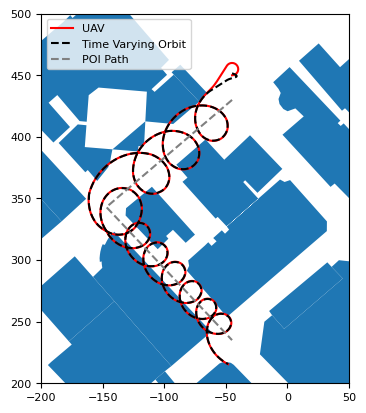

In [4]:
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(state_hist[:, 0], state_hist[:, 1], 'r')
ax.plot(radius * np.cos(theta) + trajectory[:, 0], radius * np.sin(theta) + trajectory[:, 1], 'k--')
ax.plot(trajectory[:, 0], trajectory[:, 1], '--', color='gray')
ax.legend(['UAV', 'Time Varying Orbit', 'POI Path'])

for building in city:
    ax.add_patch(pch.Polygon(building.exterior.coords))

ax.set_xlim([-200, 50])
ax.set_ylim([200, 500])
ax.set_aspect('equal', 'box')
print(f'Final Time {all_time[-1]}')

In [5]:
def getVisibility(t):
    length = 0
    i = 0
    while i < len(visibility) - 1:
        l = np.linalg.norm(visibility_points[i + 1, :] - visibility_points[i, :])
        if length / poi_speed <= t and t < (length + l) / poi_speed:
            return visibility[i], visibility[i + 1]
        i += 1
        length += l
    return visibility[-2], visibility[-1]

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


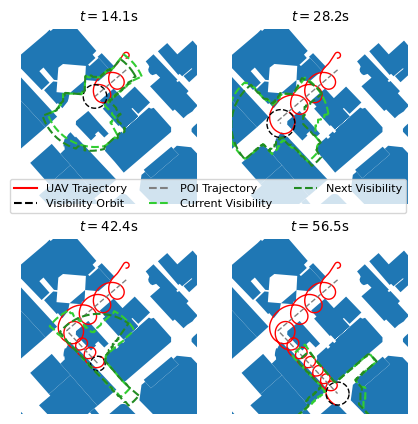

In [15]:
fig = plt.figure(figsize=(5.0, 5.0))
n = 4
axes = fig.subplots(2, 2).reshape([n])
twopi = np.linspace(0, 2 * np.pi, 100)
for i, ax in enumerate(axes):
    k = len(state_hist) * (1 + i) // n - 1
    ax.plot(state_hist[:k, 0], state_hist[:k, 1], 'r', lw=1)
    ax.plot(radius[k] * np.cos(twopi) + trajectory[k, 0], radius[k] * np.sin(twopi) + trajectory[k, 1], 'k--', lw=1)
    ax.plot(trajectory[:k, 0], trajectory[:k, 1], '--', color='gray', lw=1)
    vv0, vv1 = getVisibility(all_time[k])
    ax.plot(vv0[:, 0], vv0[:, 1], '--', color='limegreen')
    ax.plot(vv1[:, 0], vv1[:, 1], '--', color='forestgreen')
    # ax.legend(['UAV', 'Time Varying Orbit', 'POI Path'])

    for building in city:
        ax.add_patch(pch.Polygon(building.exterior.coords))

    ax.set_aspect('equal', 'datalim')
    ax.set_xlim([-200, 50])
    ax.set_ylim([200, 500])
    ax.set_axis_off()
    ax.set_title(f'$t = {all_time[k]:.1f}$s')

fig.legend(
    [
        Line2D([0], [0], color='r'),
        Line2D([0], [0], color='k', linestyle='--'),
        Line2D([0], [0], linestyle='--', color='gray'),
        Line2D([0], [0], linestyle='--', color='limegreen'),
        Line2D([0], [0], linestyle='--', color='forestgreen'),
    ],
    [
        'UAV Trajectory',
        'Visibility Orbit',
        'POI Trajectory',
        'Current Visibility',
        'Next Visibility'
    ],
    ncol=3,
    loc=8,
    bbox_to_anchor=(.5, .5)
)

fig.savefig('notebooks/figures/UAV_trajectory_small.pdf', bbox_inches='tight')

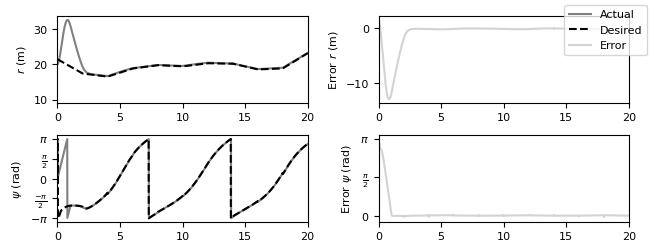

In [10]:
t_lim = 20
fig = plt.figure(figsize=(6.5, 2.5))
axes = fig.subplots(2, 2)
axes[0, 0].plot(all_time, np.linalg.norm(dist, axis=1), color='gray')
axes[0, 0].plot(all_time, radius, '--k')
axes[0, 0].set_xlim([0, t_lim])
axes[0, 0].set_ylabel('$r$ (m)')


axes[0, 1].plot(all_time, radius - np.linalg.norm(dist, axis=1), color='lightgray')
axes[0, 1].set_xlim([0, t_lim])
axes[0, 1].set_ylabel(r'Error $r$ (m)')
# axes[0, 1].set_ylim([-1, 1])

axes[1, 0].plot(all_time, (state_hist[:, 2] + np.pi) % (2 * np.pi) - np.pi, 'gray')
axes[1, 0].plot(all_time, np.arctan2(all_control[:, 1], all_control[:, 0]) ,'--k')
axes[1, 0].set_xlim([0, t_lim])
axes[1, 0].set_ylabel(r'$\psi$ (rad)')
axes[1, 0].set_yticks([-np.pi, -np.pi / 2, 0, np.pi / 2, np.pi], [r'$-\pi$', r'$\frac{-\pi}{2}$', '$0$', r'$\frac{\pi}{2}$', r'$\pi$'])

axes[1, 1].plot(all_time, (( np.arctan2(all_control[:, 1], all_control[:, 0]) - state_hist[:, 2] + np.pi) % (2 * np.pi) - np.pi), color='lightgray')
axes[1, 1].set_xlim([0, t_lim])
axes[1, 1].set_ylabel(r'Error $\psi$ (rad)')
axes[1, 1].set_yticks([0, np.pi / 2, np.pi], ['$0$', r'$\frac{\pi}{2}$', r'$\pi$'])

fig.legend(['Actual', 'Desired', 'Error'])
fig.tight_layout()
fig.savefig('notebooks/figures/controller_error_small.pdf')

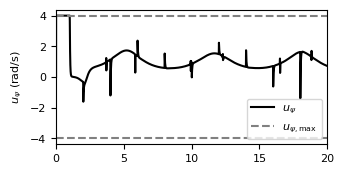

In [11]:
fig = plt.figure(figsize=(3.5, 1.75))
ax = fig.add_subplot()
ax.plot(all_time, state_hist[:, 5], 'k')
ax.set_xlim([0, t_lim])
ax.set_xticks([0, 5, 10, 15, 20])
ax.set_ylabel(r'$u_{\psi}$ (rad/s)')
ax.plot(all_time[[0, -1]], [orbits[0].speed * controller.maxcurv] * 2, '--', color='gray')
ax.plot(all_time[[0, -1]], [-orbits[0].speed * controller.maxcurv] * 2, '--', color='gray')
ax.legend([r'$u_\psi$', r'$u_{\psi, {\max}}$'])
fig.savefig('notebooks/figures/control_heading_small.pdf')